In [1]:
!python -m pip install torch torchvision torchaudio torchsummary einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.0 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
        return nn.Sequential(
            dense(dim, dim * expansion_factor),
            nn.GELU(),
            nn.Dropout(dropout),
            dense(dim * expansion_factor, dim),
            nn.Dropout(dropout)
        )

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, dropout = 0.):
        assert (image_size % patch_size) == 0, 'image must be divisible by patch size'
        num_patches = (image_size // patch_size) ** 2
        chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

        return nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear((patch_size ** 2) * channels, dim),
            *[nn.Sequential(
                PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
                PreNormResidual(dim, FeedForward(dim, expansion_factor, dropout, chan_last))
            ) for _ in range(depth)],
            nn.LayerNorm(dim),
            Reduce('b n c -> b c', 'mean'),
            nn.Linear(dim, num_classes)
        )



In [3]:
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))         

os.getcwd()
os.listdir('/kaggle/input')

data_path = '/kaggle/input/flower/flower'
assert os.path.exists(data_path), "{} path does not exist.".format(data_path) 

using cuda:0 device.


Using 3306 images for training, 364 images for validation.
100%|███████████████████████████████████████████████████████████████| 52/52 [00:54<00:00,  1.05s/it]
[Epoch 1/10] Train Loss: 1.3967, Train Accuracy: 0.3975, Validation Accuracy: 0.4643
100%|███████████████████████████████████████████████████████████████| 52/52 [00:40<00:00,  1.29it/s]
[Epoch 2/10] Train Loss: 1.1717, Train Accuracy: 0.4936, Validation Accuracy: 0.4368
100%|███████████████████████████████████████████████████████████████| 52/52 [00:40<00:00,  1.30it/s]
[Epoch 3/10] Train Loss: 1.0711, Train Accuracy: 0.5517, Validation Accuracy: 0.4505
100%|███████████████████████████████████████████████████████████████| 52/52 [00:40<00:00,  1.30it/s]
[Epoch 4/10] Train Loss: 0.9764, Train Accuracy: 0.6065, Validation Accuracy: 0.4890
100%|███████████████████████████████████████████████████████████████| 52/52 [00:40<00:00,  1.29it/s]
[Epoch 5/10] Train Loss: 0.8207, Train Accuracy: 0.6724, Validation Accuracy: 0.5055
100%|██████

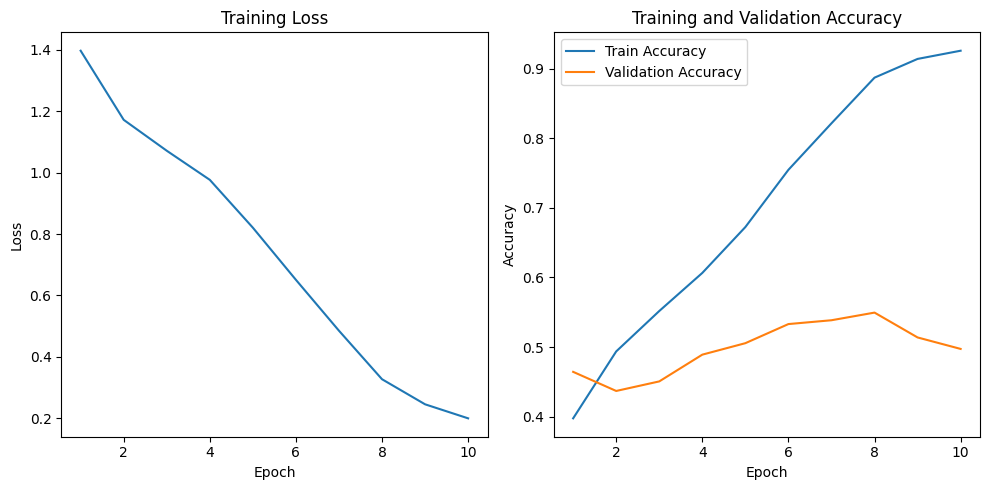

In [4]:
import os
import sys
import json
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

data_transform = {
    "train": transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),

    "val": transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

# Load datasets
train_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, "train"), transform=data_transform["train"]
)
validate_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, "val"), transform=data_transform["val"]
)
train_num = len(train_dataset)
val_num = len(validate_dataset)

# Define data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
validate_loader = torch.utils.data.DataLoader(
    validate_dataset, batch_size=4, shuffle=False
)

print(
    "Using {} images for training, {} images for validation.".format(
        train_num, val_num
    )
)

# Instantiate MLPMixer model and move to device
# model = VisionTransformer(img_size=224,
#                               patch_size=16,
#                               embed_dim=1024,
#                               depth=24,
#                               num_heads=16,
#                               representation_size=None,
#                               num_classes=num_classes)
net = MLPMixer(
    image_size=224,
    channels=3,
    patch_size=16,
    dim=512,
    depth=12,
    num_classes=5,  # Assuming 5 classes for flower dataset
).to(device)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)

# Define training parameters
#save_path = "/content/drive/MyDrive/Research/Models"
epochs = 10
#save_path = os.path.join(os.getcwd(), "results/weights/mlp_mixer")
#os.makedirs(save_path, exist_ok=True)
save_path = os.path.abspath(os.path.join(os.getcwd(), '/kaggle/working/models'))
if not os.path.exists(save_path):
    os.makedirs(save_path)

best_acc = 0.0
train_losses = []
train_accuracies = []
val_accuracies = []
# Training loop
# Training loop
for epoch in range(epochs):
    # Train
    net.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, file=sys.stdout, ncols=100):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy and loss
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate
    net.eval()
    correct_val = 0

    with torch.no_grad():
        for val_images, val_labels in validate_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = net(val_images)
            _, val_predicted = torch.max(val_outputs.data, 1)
            correct_val += (val_predicted == val_labels).sum().item()

    val_accuracy = correct_val / len(validate_loader.dataset)
    val_accuracies.append(val_accuracy)

    print(
        "[Epoch %d/%d] Train Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy: %.4f"
        % (epoch + 1, epochs, train_loss, train_accuracy, val_accuracy)
    )
    # Save the model if validation accuracy improves
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        torch.save(net.state_dict(), os.path.join(save_path, "MLPMixer.pth"))

print("Finished Training MLP-Mixer")
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

class: daisy        prob: 0.0248
class: dandelion    prob: 0.97
class: roses        prob: 0.0043
class: sunflowers   prob: 9.74e-05
class: tulips       prob: 0.0008


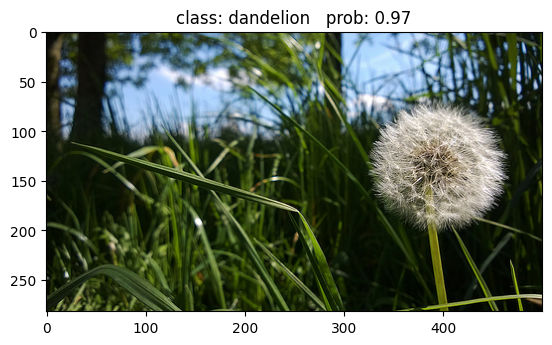

In [5]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

    # load image
#img_path = ("/content/drive/MyDrive/Research/Datasets/flower/val/roses/12406229175_82e2ac649c_n.jpg")
#img_path = ("/content/drive/MyDrive/Research/Datasets/flower/val/tulips/5012813078_99fb977616_n.jpg")
os.getcwd()

img_path = '/kaggle/input/flower/flower/val/dandelion/14185089716_2a48298d17.jpg'
# img_path = ("/kaggle/input/flower/flower/")

assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

plt.imshow(img)
    # [N, C, H, W]
img = data_transform(img)
    # expand batch dimension
img = torch.unsqueeze(img, dim=0)

    # read class_indict

json_path = "/kaggle/input/flower/flower/class_indices.json"
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

    # create model
model = MLPMixer(
    image_size=224,
    channels=3,
    patch_size=16,
    dim=512,
    depth=12,
    num_classes=5,  # Assuming 5 classes for flower dataset
).to(device)

    # load model weights
weights_path = "/kaggle/working/models/MLPMixer.pth"
#weights_path = "./results/weights/mlp_mixer/MLPMixer.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(
    weights_path
)
model.load_state_dict(torch.load(weights_path))

model.eval()
with torch.no_grad():
        # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(
    class_indict[str(predict_cla)], predict[predict_cla].numpy()
)
plt.title(print_res)
for i in range(len(predict)):
    print(
        "class: {:10}   prob: {:.3}".format(
            class_indict[str(i)], predict[i].numpy()
        )
    )
plt.show()